In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco

sns.set()

In [11]:
# 티커 리스트 정의
tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']

# EFT 객체 정의 및 OHLCV 가격 데이터 다운
etf = yf.Tickers(tickers) # 티커 객체 생성
data = etf.history(start='2010-01-01',actions=False) # ohlcv 가격 다운
data = data['Close'] # 종가 데이터만 남기기

[*********************100%%**********************]  9 of 9 completed


In [12]:
# 수익률 데이터
rets = data.pct_change().fillna(0)

# 기대수익률 계산
er = rets.mean() * 252

# 공분산행렬 계산
cov= rets.cov() * 252

### 샤프 비율 최대화 포트폴리오

In [13]:
# 샤프비율 최대화 포트폴리오 가중치 산출 함수 구현
def get_msr_weights(er, cov):
    # 자산개수
    noa = er.shape[0]
    
    # 가중치 초기값
    init_guess = np.repeat(1/noa, noa)
    
    # 자산 가중치 상하한
    bounds = ((0.0, 1.0), ) * noa
    
    # 레버리지 불가 제약 조건
    weights_sum_to_1 = {'type':'eq',
                       'fun': lambda weights: np.sum(weights) - 1}
    
    # 목적함수
    def neg_sharpe(weights, er, cov):
        r = weights.T @er
        vol = np.sqrt(weights.T @ cov @ weights)
        return - r / vol
    
    # 최적화 수행
    res = sco.minimize(neg_sharpe,
                      init_guess,
                      args=(er, cov),
                      method='SLSQP',
                      constraints=(weights_sum_to_1,),
                      bounds=bounds)
    return res.x

In [14]:
# MSR 포트폴리오 가중치
msr_weights = get_msr_weights(er, cov)

# MSR 포트폴리오 수익률
msr_ret = np.dot(msr_weights, er)

# MSR 포트폴리오 변동성
msr_vol = np.sqrt(np.dot(msr_weights.T, np.dot(cov, msr_weights)))

print(f'Return = {msr_ret}')
print(f'Volatility = {msr_vol}')

Return = 0.14258280960640396
Volatility = 0.16199924107886704


<Axes: >

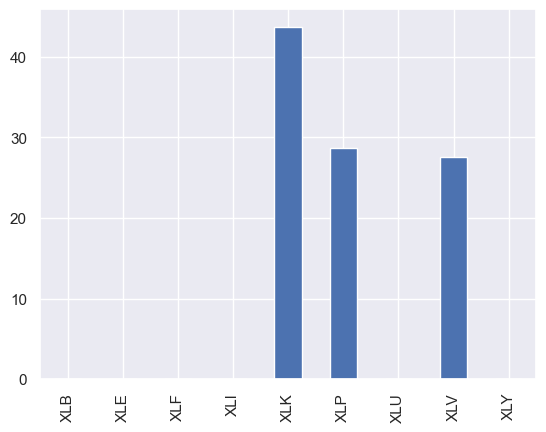

In [15]:
# 시장 포트폴리오 가중치 시각화
msr_weights_series = pd.Series(np.round(msr_weights, 4) * 100, index=tickers)
msr_weights_series.plot.bar()

### 자본시장선 구현

In [18]:
# 포트폴리오 통계치 계산 함수
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(er * weights)
    pvol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return np.array([pret, pvol, pret/pvol])

# 목적함수 정의
def obj_func(weights):
    return statistics(weights)[1]

In [21]:
# 자산의 계수
noa = len(tickers)

# 수익률 수준별 포트폴리오 최적화 수행
trets = np.linspace(0.1, 0.15, 50)
tvols = []

for tret in trets:

    # 가중치 초기값
    init_guess = np.repeat(1/noa, noa)

    # 제약조건
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # 자산 가중치 상하한
    bnds = ((0.0, 1.0), ) * noa

    # 최적화 수행
    res = sco.minimize(obj_func,
                       init_guess,
                       method='SLSQP',
                       bounds=bnds,
                       constraints=cons)

    tvols.append(res['fun'])

tvols = np.array(tvols)

In [22]:
# 좌측 경계선 데이터 수집
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

In [23]:
evols[-1]

0.17096493340003732

Text(0.5, 1.0, 'Market Portfolio & Capital Market Line')

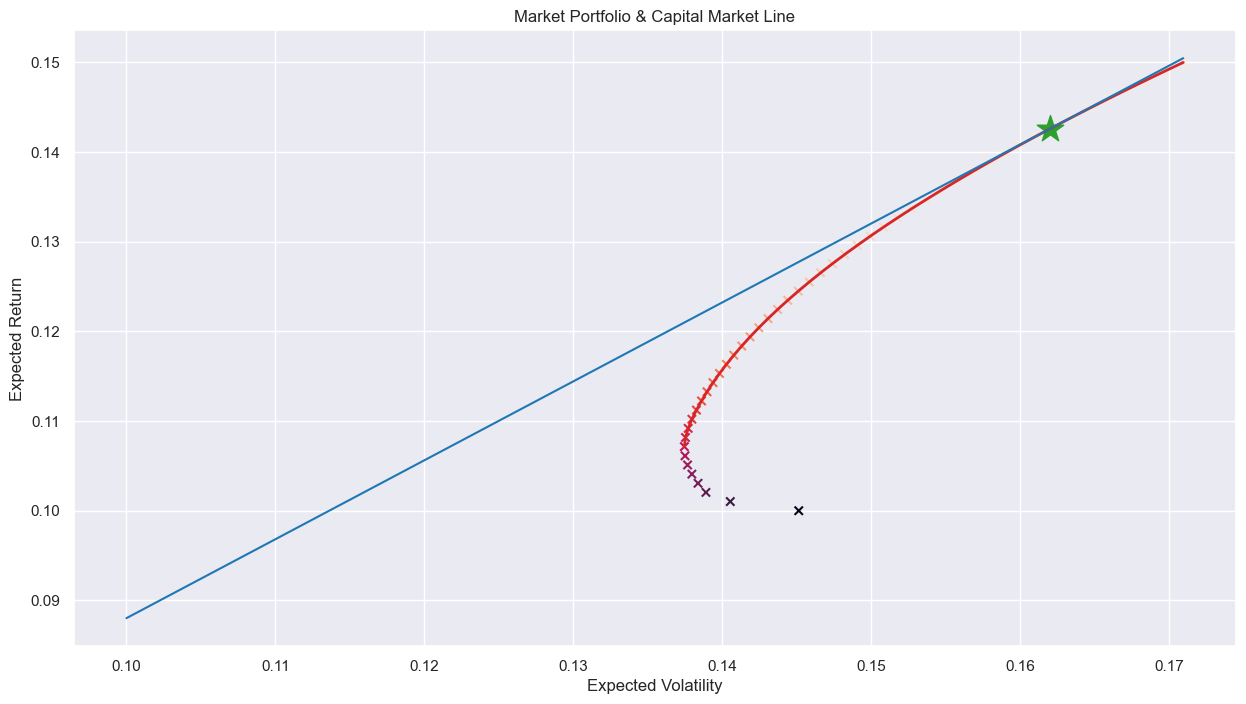

In [24]:
# 자본시장선 데이터
x = np.linspace(0.1, evols[-1], 100)
y = (msr_ret / msr_vol) * x

# 효율적 경계선 및 자본시장선 시각화
plt.figure(figsize=(15, 8))

plt.scatter(tvols, trets, c=trets/tvols, marker='x')
plt.plot(evols, erets, 'tab:red', lw=2.0)

# 시장 포트폴리오
plt.scatter(msr_vol, msr_ret, marker='*', s=400, color='tab:green')

# 자본시장선
plt.plot(x, y, 'tab:blue')

plt.grid(True)

plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')

plt.title('Market Portfolio & Capital Market Line')
